In [103]:
#Library Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import requests

In [104]:
# Raw Data Collection

# Definition of parameters for API Call
params = {
  'access_key': 'D3BD1V1XVCUGQQ2XGZIGF4F52AE2ROYH',
  'periodType' : 'year',
  'period' : '10',
  'frequencyType' : 'daily',
}

# $AAPL API Call 
api_result_aapl = requests.get('https://api.tdameritrade.com/v1/marketdata/AAPL/pricehistory?apikey=' 
                          + params['access_key'] 
                          + '&periodType='
                          + params['periodType']
                          + '&period='
                          + params['period']
                          + '&frequencyType='
                          + params['frequencyType'])

# $GOOGL API Call
api_result_googl = requests.get('https://api.tdameritrade.com/v1/marketdata/GOOGL/pricehistory?apikey=' 
                          + params['access_key'] 
                          + '&periodType='
                          + params['periodType']
                          + '&period='
                          + params['period']
                          + '&frequencyType='
                          + params['frequencyType'])

# $MSFT API Call
api_result_msft = requests.get('https://api.tdameritrade.com/v1/marketdata/MSFT/pricehistory?apikey=' 
                          + params['access_key'] 
                          + '&periodType='
                          + params['periodType']
                          + '&period='
                          + params['period']
                          + '&frequencyType='
                          + params['frequencyType'])

# $META API Call
api_result_meta = requests.get('https://api.tdameritrade.com/v1/marketdata/META/pricehistory?apikey=' 
                          + params['access_key'] 
                          + '&periodType='
                          + params['periodType']
                          + '&period='
                          + params['period']
                          + '&frequencyType='
                          + params['frequencyType'])

# Convert result to DF
def json_to_df(api_result):
    json_result = api_result.json()
    raw_data = pd.DataFrame(json_result['candles'])
    return raw_data

# Pass json to pandas data frame
raw_data_aapl = json_to_df(api_result_aapl)
raw_data_googl = json_to_df(api_result_googl)
raw_data_msft = json_to_df(api_result_msft)
raw_data_meta = json_to_df(api_result_meta)

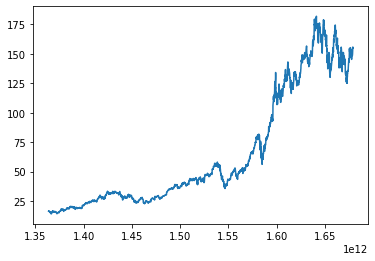

In [105]:
# Quick visualization of opening closing price over past 10 years
plt.plot(raw_data_aapl["datetime"], raw_data_aapl["close"])
plt.show()

In [106]:
# Check for missing data values
print(raw_data_aapl.isnull().sum())
print(raw_data_googl.isnull().sum())
print(raw_data_msft.isnull().sum())
print(raw_data_meta.isnull().sum())

open        0
high        0
low         0
close       0
volume      0
datetime    0
dtype: int64
open        0
high        0
low         0
close       0
volume      0
datetime    0
dtype: int64
open        0
high        0
low         0
close       0
volume      0
datetime    0
dtype: int64
open        0
high        0
low         0
close       0
volume      0
datetime    0
dtype: int64


In [107]:
# Pre-process data

# Function for creating techincal indicators
def create_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['close_aapl'].rolling(window=7).mean()
    dataset['ma21'] = dataset['close_aapl'].rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = dataset['close_aapl'].ewm(span=26).mean()
    dataset['12ema'] = dataset['close_aapl'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema'] - dataset['26ema'])
    # Create Bollinger Bands
    dataset['20sd'] = dataset['close_aapl'].rolling(20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd'] * 2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd'] * 2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['close_aapl'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['close_aapl'] - 1
    
    return dataset

# Function for joining 
data_appl_googl = pd.merge(raw_data_aapl, raw_data_googl, on=['datetime'], suffixes=('_aapl', '_googl'))
data_msft_meta = pd.merge(raw_data_meta, raw_data_msft, on=['datetime'], suffixes=('_meta', '_msft'))    
data = pd.merge(data_appl_googl, data_msft_meta, on=['datetime'])

# Assign row numbers
data = data.assign(row_number=range(len(raw_data)))

# Create technical indicators for $AAPl
data = create_technical_indicators(data)

In [108]:
# Dataset shape overview
print(data.shape)
data = data.dropna()
print(data.shape)

(2519, 32)
(2499, 32)


In [109]:
data

,open_aapl,high_aapl,low_aapl,close_aapl,volume_aapl,datetime,open_googl,high_googl,low_googl,close_googl,...,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
20,15.056071,15.236071,15.020357,15.222857,305771032,1366088400000,19.683806,19.919284,19.616992,19.853471,...,15.301531,15.709350,15.527448,15.382009,-0.145439,0.516289,16.741929,14.676772,15.191527,14.222857
21,15.009643,15.021429,14.218214,14.385714,945053840,1366174800000,19.687811,19.790285,19.471351,19.582959,...,15.182092,15.619350,15.423812,15.224747,-0.199065,0.574395,16.768140,14.470561,14.654318,13.385714
22,14.463928,14.492500,13.919357,14.001786,666296640,1366261200000,19.652777,19.664037,19.049945,19.166406,...,15.003878,15.513160,15.296854,15.032476,-0.264378,0.658826,16.830812,14.195507,14.219297,13.001786
23,13.856072,14.271429,13.753571,13.947500,609272800,1366347600000,19.247635,20.105465,19.175064,20.016129,...,14.773469,15.408483,15.178188,14.862472,-0.315717,0.721146,16.850776,13.966190,14.038099,12.947500
24,14.022857,14.364286,13.974107,14.238214,429917768,1366606800000,20.034396,20.118427,19.393776,20.022234,...,14.591531,15.316544,15.096655,14.764935,-0.331721,0.712272,16.741089,13.891999,14.171509,13.238214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2514,147.805000,153.140000,147.700000,150.470000,84457122,1678683600000,90.090000,92.570000,89.420000,91.110000,...,151.270000,150.409048,148.899327,150.103141,1.203814,2.943791,156.296629,144.521466,150.117338,149.470000
2515,151.280000,153.400000,150.100000,152.590000,73695893,1678770000000,92.560000,94.360000,92.440000,93.970000,...,151.492857,150.484286,149.172711,150.485735,1.313024,2.878354,156.240993,144.727578,151.765779,151.590000
2516,151.190000,153.245000,149.920000,152.990000,77167866,1678856400000,93.220000,96.930000,92.640000,96.110000,...,151.372857,150.443333,149.455473,150.871006,1.415534,2.867642,156.178618,144.708048,152.581926,151.990000
2517,152.160000,156.460000,151.640000,155.850000,76254419,1678942800000,96.200000,101.190000,95.500000,100.320000,...,151.980000,150.569524,149.929141,151.637005,1.707864,2.917519,156.404562,144.734485,154.760642,154.850000


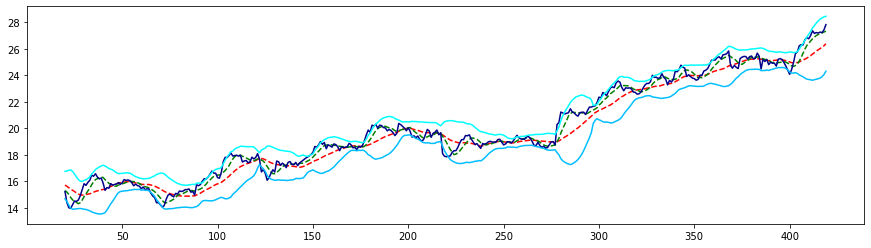

In [112]:
# Exploratory analysis of technical indicators
last400days = data.iloc[:400]
plt.figure().set_figwidth(15)
plt.plot(last400days["row_number"], last400days["ma21"], color='red', linestyle='dashed')
plt.plot(last400days["row_number"], last400days["ma7"], color='green', linestyle='dashed')
plt.plot(last400days["row_number"], last400days["close_aapl"], color='darkblue')
plt.plot(last400days["row_number"], last400days["upper_band"], color='cyan')
plt.plot(last400days["row_number"], last400days["lower_band"], color='deepskyblue')
plt.show()